# Sarcasm Detection in Online Discourse

In [1]:
# Install necessary packages

import pandas as pd
import numpy as np

#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt

import sklearn
import nltk

# The following are not included with anaconda so have pip install commands
#!pip install gensim
#!pip install textblob
#!pip install joblib
import gensim
from textblob import TextBlob
import joblib

import json
import gc
from copy import deepcopy

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {return false;}

<IPython.core.display.Javascript object>

# Get and Prepare Data
The dataset used is the Self Annoted Reddit Corpus (SARC), Khodak et al., 2018. This is a large dataset of annotated sarcastic reddit comments and accompanying metadata (subreddit, author, etc).

In [3]:
# Get datasets and place into dataframes
# Attempt to read from local file first
# Read from url if impossible and create local file for future use

columns = ["label", "comment", "author", "subreddit", "score", "ups", "downs", "date", "created_utc", "parent_comment"]

try:
    print("Reading from file...")
    test_balanced = pd.read_csv('data/test-balanced.csv.bz2', compression='bz2')
    train_balanced = pd.read_csv('data/train-balanced.csv.bz2', compression='bz2')
    print("Read successfully!")
except:
    print("No local file")
    print("Downloading...")
    test_balanced = pd.read_csv("http://nlp.cs.princeton.edu/SARC/1.0/main/test-balanced.csv.bz2", compression="bz2", sep="\t", header=None, names=columns)
    train_balanced = pd.read_csv("http://nlp.cs.princeton.edu/SARC/1.0/main/train-balanced.csv.bz2", compression="bz2", sep="\t", header=None, names=columns)
    print("Downloaded!")
    print("Creating local copy...")
    test_balanced.to_csv('data/test-balanced.csv.bz2', compression='bz2', index=False)
    train_balanced.to_csv('data/train-balanced.csv.bz2', compression='bz2', index=False)
    print("Local copy created successfully!")

Reading from file...
Read successfully!


In [4]:
data_types = {
    "label": "int",
    "comment": "unicode",
    "author": "unicode",
    "subreddit": "unicode",
    "score": np.float64,
    "ups": "int",
    "downs": "int",
    "date": "object",
    "created_utc": "object",
    "parent_comment": "unicode"
}

train_balanced = train_balanced.astype(data_types)
test_balanced = test_balanced.astype(data_types)

In [5]:
train_balanced['datetime'] = pd.to_datetime(train_balanced['created_utc'], unit='s')
test_balanced['datetime'] = pd.to_datetime(test_balanced['created_utc'], unit='s')

In [6]:
# So as not to run out of memory, only use a part of the dataset

balanced = True
n_samples = 100000
train_n1 = train_n2 = int(n_samples/2)
if (balanced):
    test_n1 = test_n2 = int(n_samples/8)
else:
    test_n1 = int((n_samples/5) - (n_samples/500))
    test_n2 = int(n_samples/500)

train = pd.concat((
    train_balanced[train_balanced['label'] == 0].sample(n=train_n1),
    train_balanced[train_balanced['label'] == 1].sample(n=train_n2)
)).sample(frac=1)
test = pd.concat((
    test_balanced[test_balanced['label'] == 0].sample(n=test_n1),
    test_balanced[test_balanced['label'] == 1].sample(n=test_n2)
)).sample(frac=1)

#train = train_balanced
#test = test_balanced

In [7]:
print(train.shape[0], test.shape[0])

100000 25000


In [8]:
#train_0 = train_balanced[train_balanced['label'] == 0]
#train_1 = train_balanced[train_balanced['label'] == 1]
#test_0 = test_balanced[test_balanced['label'] == 0]
#test_1 = test_balanced[test_balanced['label'] == 1]
#
#train = pd.concat((
#    train_0.iloc[:int(len(train_0.index)/2)],
#    train_1.iloc[:int(len(train_1.index)/2)]
#)).sample(frac=1).iloc[:20000]
#test = pd.concat((
#    test_0.iloc[int(len(test_0.index)/2):],
#    test_1.iloc[int(len(test_1.index)/2):]
#)).sample(frac=1).iloc[:5000]
#
#subreddit_train = pd.concat((
#    train_0.iloc[:int(len(train_0.index)/2)],
#    train_1.iloc[:int(len(train_1.index)/2)]
#)).sample(frac=1)
#subreddit_test = pd.concat((
#    test_0.iloc[int(len(test_0.index)/2):],
#    test_1.iloc[int(len(test_1.index)/2):]
#)).sample(frac=1)

In [9]:
train.head()

label                                            comment  \
265858       1  Well sure... the middle of a restaurant is a w...   
1089705      0  I'd rather be the only rational person on the ...   
116894       1             You are right, it should be forgotten.   
1121687      1  So what's a little tar sands in the local craf...   
610313       0    generic kpop is so much better with Conan in it   

                     author      subreddit  score  ups  downs     date  \
265858   gin_and_uterotonic  beyondthebump   12.0   -1     -1  2016-11   
1089705         greenwizard        atheism    1.0    1      0  2011-02   
116894         Mr_Golyadkin         europe   10.0   -1     -1  2017-03   
1121687               alwen       Michigan    3.0    3      0  2013-07   
610313         Herodahdahna     television    2.0    2      0  2016-04   

        created_utc                                     parent_comment  \
265858   1480146907  Breastfeeding in public and only one person ha...   
1089705  1298384609  These "forever alone" comics aren't even funny...   
116894   1489868564  So Im sure this post is just for information s...   
1121687  1374760619  Bell's Brewery files lawsuit against Enbridge ...   
610313   1460270781  J.Y. Park "Fire" feat. Conan O'Brien &amp; Ste...   

                   datetime  
265858  2016-11-26 07:55:07  
1089705 2011-02-22 14:23:29  
116894  2017-03-18 20:22:44  
1121687 2013-07-25 13:56:59  
610313  2016-04-10 06:46:21

# Classifier Preperation
Necessary functions and classes are imported and classes for each feature are built.

In [10]:
# Tokenizer function

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

tokenizer = RegexpTokenizer(r'\w+')

def tokenize(string):
    normalized_tokens = list()
    tokens = tokenizer.tokenize(string)
    for token in tokens:
        if (len(token) > 1):
            normalized = token.lower()
            normalized_tokens.append(normalized)
    return normalized_tokens

def stem_tokenizer(string):
    normalized_tokens = list()
    tokens = tokenizer.tokenize(string)
    for token in tokens:
        if len(token) > 1:
            normalized = token.lower()
            normalized = stemmer.stem(normalized)
            normalized_tokens.append(normalized)
    return normalized_tokens

def stop_tokenizer(string):
    normalized_tokens = list()
    tokens = tokenizer.tokenize(string)
    for token in tokens:
        if token.lower() not in stop_words and len(token) > 1:
            normalized = token.lower()
            normalized_tokens.append(normalized)
    return normalized_tokens

def stem_stop_tokenizer(string):
    normalized_tokens = list()
    tokens = tokenizer.tokenize(string)
    for token in tokens:
        if token.lower() not in stop_words and len(token) > 1:
            normalized = token.lower()
            normalized = stemmer.stem(normalized)
            normalized_tokens.append(normalized)
    return normalized_tokens

[nltk_data] Downloading package stopwords to /home/summer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
# Evaluation function

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report, confusion_matrix

def eval_summary(name, predictions, labels, metric="accuracy"):
    precision = precision_score(labels, predictions)
    recall = recall_score(labels, predictions)
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions)
    print('\nConfusion matrix:\n',confusion_matrix(labels, predictions))
    print("Classifier '%s' has P=%0.3f R=%0.3f Acc=%0.3f F1=%0.3f" % (name, precision, recall, accuracy, f1))
    print(classification_report(labels, predictions))
    
    if (metric.lower() == "accuracy"):
        return accuracy
    elif (metric.lower() == "precision"):
        return precision
    elif (metric.lower() == "recall"):
        return recall
    elif (metric.lower() == "f1"):
        return f1
    elif (metric.lower() == "all"):
        return [acuuracy, precision, recall, f1]

In [12]:
# Sklearn packages

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, MaxAbsScaler

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import VarianceThreshold, SelectKBest, RFE

In [13]:
# Handle other packages

from datetime import datetime, timedelta

from gensim.models.ldamodel import  LdaModel
from gensim.corpora import Dictionary

from scipy.sparse import csr_matrix

from multiprocessing import Pool, cpu_count

nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/summer/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [14]:
# Transformation classes
    
class SubredditSarcasm(BaseEstimator, TransformerMixin):
    def __init__(self, history=None, n_workers=None):
        self.history = history
        if (n_workers == None):
            self.n_workers = cpu_count() - 1
        else:
            self.n_workers = n_workers
            
        
    def fit(self, X, y=None):
        if (self.history == None):
            self.history = {}
            for _, post in X.iterrows():
                if post['subreddit'] not in self.history:
                    self.history[post['subreddit']] = {'0': 0, '1': 1}
                
                self.history[post['subreddit']][str(post['label'])] += 1
                    
        return self
    
    def transform(self, X):
        pool = Pool(self.n_workers)
        try:
            sub_sarc = pool.map(self.getSarcasmHistory, X['subreddit'])
        except:
            pool.close()
        pool.close()
        return sub_sarc
    
    def getSarcasmHistory(self, subreddit):
        try:
            return(self.history[subreddit]['1'] / (self.history[subreddit]['0'] + self.history[subreddit]['1']))
        except:
            return 0.0
    
class AuthorSarcasm(BaseEstimator, TransformerMixin):
    def __init__(self, history=None, n_workers=None):
        self.history = history
        if (n_workers == None):
            self.n_workers = cpu_count() - 1
        else:
            self.n_workers = n_workers
        
    def fit(self, X, y=None):
        if (self.history == None):
            self.today = X.sort_values(by=['datetime'], ascending=False).iloc[0]['datetime']
            self.last_week = self.today - timedelta(weeks=1)
            self.last_month = self.last_week - timedelta(weeks=4)
            self.last_six_months = self.last_month - timedelta(weeks=24)
            self.last_year = self.last_six_months - timedelta(days=365)
            
            self.history = {}
            zero_times = {
                'last_month': 0,
                'last_six_months': 0,
                'last_year': 0,
                'earlier': 0
            }
            
            for _, post in X.iterrows():
                if post['author'] not in self.history:
                    self.history[post['author']] = {'0': zero_times.copy(), '1': zero_times.copy()}
                    
                if (post['datetime'] >= self.last_month):
                    time = 'last_month'
                elif (post['datetime'] >= self.last_six_months):
                    time = 'last_six_months'
                elif (post['datetime'] >= self.last_year):
                    time = 'last_year'
                else:
                    time = 'earlier'
                    
                self.history[post['author']][str(post['label'])][time] += 1
            
        return self
    
    def transform(self, X):  
        pool = Pool(self.n_workers)
        try:
            auth_sarc = pool.map(self.getAuthorSarcasmHistory, X['author'])
        except:
            pool.close()
        pool.close()
        return np.vstack(auth_sarc)
    
    def getAuthorSarcasmHistory(self, author):
        author_hist = np.zeros(4)
        for i, time in enumerate(['last_week', 'last_month', 'last_year', 'earlier']):
            try:
                author_hist[i] = float(
                    self.history[author]['1'][time] /
                    (self.history[author]['0'][time] + self.history[author]['1'][time])
                )
            except:
                author_hist[i] = 0.0
            
        return author_hist
    
class CommentLength(BaseEstimator, TransformerMixin):
    def __init__(self, term="sentence", n_workers=None):
        self.term = term
        
        if (n_workers == None):
            self.n_workers = cpu_count() -1
        else:
            self.n_workers = n_workers
            
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        pool = Pool(self.n_workers)
        try:
            lengths = pool.map(self.getLength, X)
        except:
            pool.close()
        pool.close()
        return lengths
    
    def getLength(self, comment):
        if (self.term == "character"):
            return len(comment)
        elif (self.term == "word"):
            return len(TextBlob(comment).words)
        elif (self.term == "sentence"):
            return len(TextBlob(comment).sentences)
    
class OverallSentiment(BaseEstimator, TransformerMixin):
    def __init(self, n_workers=None):
        if (n_workers == None):
            self.n_workers = cpu_count() - 1
        else:
            self.n_workers = n_workers
            
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        pool = Pool(self.n_workers)
        try:
            sentiments = pool.map(self.getSentiment, X)
        except:
            pool.close()
        pool.close()
        return np.vstack(sentiments)
    
    def getSentiment(self, comment):
        sentiments = np.zeros(2)
        sent = TextBlob(comment).sentiment
        sentiments[0] = sent.polarity
        sentiments[1] = sent.subjectivity
        return sentiments
    
class Polarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_workers=None):
        if (n_workers == None):
            self.n_workers = cpu_count() - 1
        else:
            self.n_workers = n_workers
            
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        pool = Pool(self.n_workers)
        try:
            polarity = pool.map(self.getPolarity, X)
        except:
            pool.close()
        pool.close()
        return polarity
        
    def getPolarity(self, comment):
        return TextBlob(comment).sentiment.polarity
    
class Subjectivity(BaseEstimator, TransformerMixin):
    def __init__(self, n_workers=None):
        if (n_workers == None):
            self.n_workers = cpu_count() - 1
        else:
            self.n_workers = n_workers
            
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        pool = Pool(self.n_workers)
        try:
            subjectivity = pool.map(self.getSubjectivity, X)
        except:
            pool.close()
        pool.close()
        return subjectivity
        
    def getSubjectivity(self, comment):
        return TextBlob(comment).sentiment.subjectivity
    
class SentimentDifference(BaseEstimator, TransformerMixin):
    def __init__(self, n_workers=None):
        if (n_workers == None):
            self.n_workers = cpu_count() - 1
        else:
            self.n_workers = n_workers
            
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        pool = Pool(self.n_workers)
        try:
            sent_diff = pool.map(self.getSentDiff, X)
        except:
            pool.close()
        pool.close()
        return sent_diff
        #return X.apply(lambda x: self.getSentDiff(x))
    
    def getSentDiff(self, comment):
        blob = TextBlob(comment)
        sentences = blob.sentences
        
        if (len(sentences) == 1):
            words = blob.words
            l = len(words)
            first = words[:int(l/2)]
            second = words[int(l/2):]
            return abs(TextBlob(str(first)).subjectivity - TextBlob(str(second)).sentiment.subjectivity)
        
        else:
            l = len(sentences)
            first = sentences[:int(l/2)]
            second = sentences[int(l/2):]
            return abs(
                np.mean([sentence.subjectivity for sentence in first]) -
                np.mean([sentence.subjectivity for sentence in second])
            )
    
class SentDiffPerSentence(BaseEstimator, TransformerMixin):
    def __init__(self, agg=np.mean, n_workers=None):
        self.agg = agg
        
        if (n_workers == None):
            self.n_workers = cpu_count() - 1
        else:
            self.n_workers = n_workers
            
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        pool = Pool(self.n_workers)
        try:
            sent_diff = pool.map(self.getSentDiff, X)
        except:
            pool.close()
        pool.close()
        return sent_diff
    
    def getSentDiff(self, comment):
        sentences = TextBlob(comment).sentences
        diffs = np.zeros(len(sentences))
        
        for i, sentence in enumerate(sentences):
            words = sentence.words
            l = len(words)
            
            diffs[i] = abs(TextBlob(str(words[:int(l/2)])).polarity - TextBlob(str(words[int(l/2):])).polarity)
            
        return self.agg(diffs)
    
class TopicExtractor(BaseEstimator, TransformerMixin):
    '''Returns the most prominent topics for each document in the corpus'''
    def __init__(
        self,
        num_topics=100,
        display=False,
        minimum_probability=0.01,
        ldaModel=None,
        dictionary=None,
        alpha=1,
        tokenizer=stem_stop_tokenizer,
        n_workers=None
    ):
        self.num_topics = num_topics
        self.display = display
        self.minimum_probability = minimum_probability
        self.ldaModel = ldaModel
        self.dictionary = dictionary
        self.alpha = alpha
        self.tokenize = tokenizer
        if (n_workers == None):
            self.n_workers = cpu_count() - 1
        else:
            self.n_workers = n_workers
    
    def fit(self, X, y=None):
        if (self.ldaModel == None):
            self.display and print("Tokenizing coments...")
            tokenized_text = X.apply(lambda comment: self.tokenize(comment))
            self.display and print("Preparing dictionary...")
            self.dictionary = Dictionary(tokenized_text)
            self.display and print("Creating corpus...")
            corpus = [self.dictionary.doc2bow(text) for text in tokenized_text]

            self.display and print("Initializing LDA Model...")
            self.ldaModel = LdaMulticore(
                corpus,
                num_topics=self.num_topics,
                id2word=self.dictionary,
                alpha=self.alpha,
                minimum_probability=self.minimum_probability
            )

            self.display and print("Done!\n")
            if (self.display):
                for topics in self.ldaModel.print_topics():
                    print(topics)
        return self
    
    def transform(self, X):
        pool = Pool(self.n_workers)
        try:
            topics = pool.map(self.getTopics, X)
        except:
            pool.close()
        pool.close()
        return np.vstack(topics)
        
        #tokenized_text = X.apply(lambda comment: self.tokenize(comment))
        #corpus = [self.dictionary.doc2bow(text) for text in tokenized_text]
        #all_doc_topics = [self.ldaModel[doc] for doc in corpus]
        #
        #data = list()
        #rows = list()
        #cols = list()
        #for i, doc_topics in enumerate(all_doc_topics):
        #    for topic in doc_topics:
        #        data.append(topic[1])
        #        rows.append(i)
        #        cols.append(topic[0])
        #
        #return scipy.sparse.csr_matrix((data, (rows, cols)), shape=(len(corpus), self.num_topics))
    
    def getTopics(self, comment):
        topics = self.ldaModel.get_document_topics(
            self.dictionary.doc2bow(self.tokenize(comment)),
            minimum_probability = self.minimum_probability
        )
        
        topic_matrix = np.zeros(100)
        for topic in topics:
            topic_matrix[topic[0]] = topic[1]
            
        return topic_matrix
        
    
class PoSTags(BaseEstimator, TransformerMixin):
    def __init__(self, n_workers=None):
        all_tags = [
            '$', '\'\'', '(', ')', ',', '--', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS',
            'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM',
            'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``', 'None'
        ]
        
        self.tag_to_i = {}
        for i, tag in enumerate(all_tags):
            self.tag_to_i[tag] = i
        if (n_workers == None):
            self.n_workers = cpu_count() - 1
        else:
            self.n_workers = n_workers
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        pool = Pool(self.n_workers)
        try:
            pos = pool.map(self.getPoSTags, X)
        except:
            pool.close()
        pool.close()
        return np.vstack(pos)
    
    def getPoSTags(self, comment):
        tokens = nltk.word_tokenize(comment)
        tags = nltk.pos_tag(tokens)
        pos = np.zeros(len(self.tag_to_i))
        
        for tag in tags:
            if (tag[1] in self.tag_to_i):
                pos[self.tag_to_i[tag[1]]] += 1
        
        if (len(tokens) > 0):
            return np.nan_to_num(pos / len(tokens))
        else:
            return pos

In [15]:
# Utility classes

class ColumnSelector(BaseEstimator, TransformerMixin):
    '''Returns a single column from a dataframe'''
    def __init__(self, column):
        self.column = column
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.column]

class OneDReshaper(BaseEstimator, TransformerMixin):
    '''Converts a 1D array to a 2D array with one dimension 1 to fit scikit-learn transformers'''
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.values.reshape(-1, 1)
    
class ToArray(BaseEstimator, TransformerMixin):
    '''Converts pandas series to numpy arrays'''
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.toarray()
    
class ToNpArray(BaseEstimator, TransformerMixin):
    '''Converts lists to numpy arrays'''
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        arr = np.array(X)
        return arr.reshape(-1, 1)
    
class Printer(BaseEstimator, TransformerMixin):
    '''Provides debug output'''
    def __init(self, n_rows=20):
        self.n_rows = n_rows
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        print(X[:n_rows])
        print(X.shape)
        return X

# Individual Feature Testing
Each feature is tested seperately, the f1 score being calculated

In [26]:
# Get existing model data is possible

try:
    with open('models/author_history.json') as f:
        author_history = json.load(f)
    print("Author sarcasm history read from file")
except:
    author_history = None
    print("No author sarcasm history - will be constructed from training data")

try:
    with open('models/subreddit_history.json') as f:
        subreddit_history = json.load(f)
    print("Subreddit sarcasm history read from file")
except:
    subreddit_history = None
    print("No subreddit sarcasm history - will be constructed from training data")
    
try:
    ldaModel = LdaModel.load('models/ldamodel.model')
    dictionary = Dictionary.load('models/dictionary.dict')
    print("LDAModel and dictionary read from file")
except:
    ldaModel = None
    dictionary = None
    print("No LDAModel or dictionary - will be constructed from training data")
    
try:
    parent_ldaModel = LdaModel.load('models/parent_ldamodel.model')
    parent_dictionary = Dictionary.load('models/parent_dictionary.dict')
    print("Parent comment LDAModel and dictionary read from file")
except:
    parent_ldaModel = None
    parent_dictionary = None
    print("No parent comment LDAModel or dictionary - will be constructed from training data")

Author sarcasm history read from file
Subreddit sarcasm history read from file
LDAModel and dictionary read from file
Parent comment LDAModel and dictionary read from file


In [19]:
# The seperate features

features = [
    ("n_grams", Pipeline([
        ('selector', ColumnSelector('comment')),
        ('vect', TfidfVectorizer(binary=True, ngram_range=(1,2), tokenizer=tokenize))
    ])),
    ("parent_n_grams", Pipeline([
        ('selector', ColumnSelector('parent_comment')),
        ('vect', TfidfVectorizer(binary=True, ngram_range=(1,2), tokenizer=tokenize))
    ])),
    ("score", Pipeline([
       ('selector', ColumnSelector('score')),
       ('reshape', OneDReshaper()),
    ])),
    ("length", Pipeline([
        ('selector', ColumnSelector('comment')),
        ('length', CommentLength(term="sentence")),
        ('reshape', ToNpArray())
    ])),
    ("subreddit_sarcasm", Pipeline([
        ('sarcasm', SubredditSarcasm(history=subreddit_history)),
        ('toarray', ToNpArray()),
    ])),
    ("author_sarcasm", Pipeline([
        ('sarcasm', AuthorSarcasm(history=author_history)),
    ])),
    ("polarity", Pipeline([
       ("selector", ColumnSelector("comment")),
       ('polarity', Polarity()),
       ('reshape', ToNpArray())
    ])),
    ("subjectivity", Pipeline([
       ("selector", ColumnSelector("comment")),
       ('polarity', Subjectivity()),
       ('reshape', ToNpArray())
    ])),
    ("sentence_sentiment_difference", Pipeline([
        ('selector', ColumnSelector('comment')),
        ('difference', SentDiffPerSentence()),
        ('toarray', ToNpArray()),
    ])),
    ("topics", Pipeline([
        ('selector', ColumnSelector('comment')),
        ('topics', TopicExtractor(ldaModel=ldaModel, dictionary=dictionary, minimum_probability=0.1)),
    ])),
    ("parent_topics", Pipeline([
        ('selector', ColumnSelector('parent_comment')),
        ('topics', TopicExtractor(ldaModel=parent_ldaModel, dictionary=parent_dictionary, minimum_probability=0.1))
    ])),
    ("pos_tags", Pipeline([
        ('selector', ColumnSelector('comment')),
        ('pos_tags', PoSTags())
    ])),
]

features_that_work = [
    ("n_grams", Pipeline([
        ('selector', ColumnSelector('comment')),
        ('vect', TfidfVectorizer(binary=True, ngram_range=(1,2), tokenizer=tokenize))
    ])),
    ("subreddit_sarcasm", Pipeline([
        ('sarcasm', SubredditSarcasm(history=subreddit_history)),
        ('toarray', ToNpArray()),
    ])),
    #("sentiment_difference", Pipeline([
    #    ('selector', ColumnSelector('comment')),
    #    ('difference', SentimentDifference()),
    #    ('toarray', ToNpArray()),
    #])),
    ("topics", Pipeline([
        ('selector', ColumnSelector('comment')),
        ('topics', TopicExtractor(ldaModel=ldaModel, dictionary=dictionary)),
    ])),
    ("pos_tags", Pipeline([
        ('selector', ColumnSelector('comment')),
        ('pos_tags', PoSTags())
    ])),
    ("parent_topics", Pipeline([
        ('selector', ColumnSelector('parent_comment')),
        ('topics', TopicExtractor(ldaModel=parent_ldaModel, dictionary=parent_dictionary))
    ])),
    ("parent_n_grams", Pipeline([
        ('selector', ColumnSelector('parent_comment')),
        ('vect', TfidfVectorizer(binary=True, ngram_range=(1,2), tokenizer=tokenize))
    ])),
]

#clf = LinearSVC(C=0.1)
clf = LogisticRegression(C=1)
#clf = MultinomialNB(alpha=10)

## Helper Functions

In [16]:
# Test Features Seperately

def featureTest(features, clf, train=train, test=test, combined=False, saveas=None, metric="accuracy"):
    results = list()
    
    for feature in features:
        feature_pipeline = Pipeline([
            ('feature', feature[1]),
            ('scaler', MaxAbsScaler()),
            ('clf', clf)
        ])
        feature_pipeline.fit(train, train['label'])
        results.append(eval_summary(feature[0], feature_pipeline.predict(test), test['label'], metric="accuracy"))
        
        if (saveas is not None):
            joblib.dump(feature_pipeline, "models/individuals/{}.joblib".format(feature[0]))
        
        del feature
        gc.collect()
        
    if (combined):
        combined_pipeline = Pipeline([
            ('features', FeatureUnion(features)),
            ('scaler', MaxAbsScaler()),
            ('clf', clf)
        ])
        combined_pipeline.fit(train, train['label'])
        results.append(eval_summary("Combined Features", combined_pipeline.predict(test), test['label'], metric="accuracy"))
        
        if (saveas is not None):
            joblib.dump(combined_pipeline, "models/{}.joblib".format(saveas))
            
    return results

In [17]:
# Plot bar chart of values

def plotBar(data, ticks=None, title=None, x_label=None, y_label=None, y_lim=None, show_vals=False, saveas=None, **kwargs):
    plt.figure()
    plt.tight_layout()
    
    plt.bar(range(len(data)), data, **kwargs)
    
    if (ticks is not None):
        plt.xticks(range(len(ticks)), ticks, rotation='vertical')
    if (title is not None):
        plt.title(np.array(title))
    if (x_label is not None):
        plt.xlabel(x_label)
    if (y_label is not None):
        plt.ylabel(y_label)
    if (y_lim is not None):
        if (isinstance(y_lim, tuple)):
            plt.ylim(y_lim)
        else:
            plt.ylim(top=y_lim)
    if (show_vals):
        for i, val in enumerate(data):
            plt.text(i, val + 0.02, '%.2f' % val, horizontalalignment='center', fontsize=12)
            
    if (saveas != None):
        plt.savefig("graphs/{}.png".format(saveas), bbox_inches="tight")

# Experiment

In [22]:
scores = featureTest(deepcopy(features), LogisticRegression(), combined=True, saveas="combined_all")


Confusion matrix:
 [[8464 4036]
 [3885 8615]]
Classifier 'n_grams' has P=0.681 R=0.689 Acc=0.683 F1=0.685
             precision    recall  f1-score   support

          0       0.69      0.68      0.68     12500
          1       0.68      0.69      0.69     12500

avg / total       0.68      0.68      0.68     25000


Confusion matrix:
 [[6686 5814]
 [5336 7164]]
Classifier 'parent_n_grams' has P=0.552 R=0.573 Acc=0.554 F1=0.562
             precision    recall  f1-score   support

          0       0.56      0.53      0.55     12500
          1       0.55      0.57      0.56     12500

avg / total       0.55      0.55      0.55     25000


Confusion matrix:
 [[ 2233 10267]
 [ 2501  9999]]
Classifier 'score' has P=0.493 R=0.800 Acc=0.489 F1=0.610
             precision    recall  f1-score   support

          0       0.47      0.18      0.26     12500
          1       0.49      0.80      0.61     12500

avg / total       0.48      0.49      0.43     25000


Confusion matrix:
 [[   

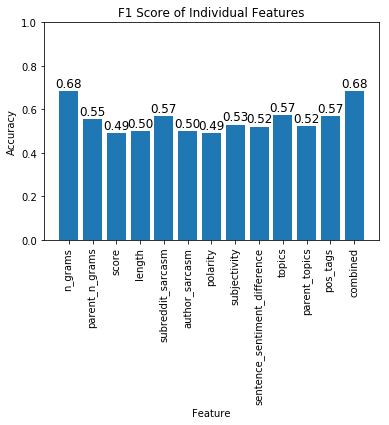

In [23]:
feature_names = np.append([feature[0] for feature in features], "combined")
plotBar(scores, feature_names, "F1 Score of Individual Features", x_label="Feature", y_label="Accuracy", show_vals=True, y_lim=1, saveas="combined_all")

In [24]:
for name, score in zip(feature_names, scores):
    print("{}: {}".format(name, score))

n_grams: 0.68316
parent_n_grams: 0.554
score: 0.48928
length: 0.5002
subreddit_sarcasm: 0.56752
author_sarcasm: 0.49996
polarity: 0.48868
subjectivity: 0.5292
sentence_sentiment_difference: 0.52008
topics: 0.57336
parent_topics: 0.52152
pos_tags: 0.56904
combined: 0.68232


In [25]:
good_feature_args = np.where(np.array(scores[:-1]) > 0.51)[0]
good_features = list()
for arg in good_feature_args:
    good_features.append(features[arg])

In [26]:
good_scores = featureTest(deepcopy(good_features), LogisticRegression(), combined=True, saveas="combined_best")


Confusion matrix:
 [[8464 4036]
 [3885 8615]]
Classifier 'n_grams' has P=0.681 R=0.689 Acc=0.683 F1=0.685
             precision    recall  f1-score   support

          0       0.69      0.68      0.68     12500
          1       0.68      0.69      0.69     12500

avg / total       0.68      0.68      0.68     25000


Confusion matrix:
 [[6686 5814]
 [5336 7164]]
Classifier 'parent_n_grams' has P=0.552 R=0.573 Acc=0.554 F1=0.562
             precision    recall  f1-score   support

          0       0.56      0.53      0.55     12500
          1       0.55      0.57      0.56     12500

avg / total       0.55      0.55      0.55     25000


Confusion matrix:
 [[6792 5708]
 [5104 7396]]
Classifier 'subreddit_sarcasm' has P=0.564 R=0.592 Acc=0.568 F1=0.578
             precision    recall  f1-score   support

          0       0.57      0.54      0.56     12500
          1       0.56      0.59      0.58     12500

avg / total       0.57      0.57      0.57     25000


Confusion matrix

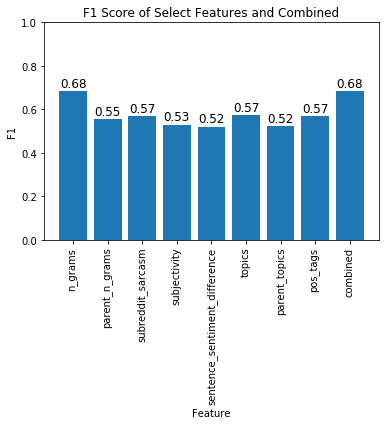

In [27]:
good_feature_names = np.append([feature[0] for feature in good_features], "combined")
plotBar(good_scores, good_feature_names, "F1 Score of Select Features and Combined", x_label="Feature", y_label="F1", show_vals=True, y_lim=1, saveas="combined_best")

In [28]:
for name, score in zip(good_feature_names, good_scores):
    print("{}: {}".format(name, score))

n_grams: 0.68316
parent_n_grams: 0.554
subreddit_sarcasm: 0.56752
subjectivity: 0.5292
sentence_sentiment_difference: 0.52008
topics: 0.57336
parent_topics: 0.52152
pos_tags: 0.56904
combined: 0.68156


## N-grams plus one

In [32]:
# Test features combined with n-grams
plus_results = list()
result_names = list()

tmp_ngram = deepcopy(features[0][1])
    
clf = Pipeline([
    ('feature', tmp_ngram),
    ('scaler', MaxAbsScaler()),
    ('clf', clf)
])
clf.fit(train, train['label'])
plus_results.append(eval_summary("Plus None", clf.predict(test), test['label']))
result_names.append("None")
    
for feature in deepcopy(features[1:]):
    plus_clf = Pipeline([
        ('features', FeatureUnion((tmp_ngram, feature))),
        ('scaler', MaxAbsScaler()),
        ('clf', clf)
    ])
    plus_clf.fit(train, train['label'])
    plus_results.append(eval_summary("Plus {}".format(feature[0]), plus_clf.predict(test), test['label']))
    result_names.append(feature[0])

AssertionError: 

In [ ]:
for name, score in zip(result_names, plus_results):
    print("{}: {}".format(name, score))

## Old stuff

In [ ]:
# Testing features seperately

f1_results = list()

for feature in deepcopy(features):
    feature_pipeline = Pipeline([
        ('feature', feature[1]),
        ('clf', LogisticRegression(C=1))
    ])
    feature_pipeline.fit(train, train['label'])
    f1_results.append(eval_summary(feature[0], feature_pipeline.predict(test), test['label']))
    #f1_results.append(np.mean(cross_val_score(feature_pipeline, train, train['label'], cv=5)))
    
gc.collect()

In [ ]:
plt.bar(range(len(f1_results)), f1_results)
for i, f1 in enumerate(f1_results):
    plt.text(i, f1 + 0.02, '%.2f' % f1, horizontalalignment='center', fontsize=12)
plt.xticks(range(len(f1_results)), [feature[0] for feature in features], rotation='vertical')
plt.ylim(0,1)

plt.title("Single Feature Testing")
plt.xlabel("Feature")
plt.ylabel("F1 Score")

# Combined Features

Multiple features combined into one model

## All features

In [ ]:
# Combined features

combined_pipeline = Pipeline([
    ('features', FeatureUnion(deepcopy(features))),
    ('clf', LogisticRegression(C=1))
])

In [ ]:
combined_pipeline.fit(train, train['label'])

In [ ]:
combined_f1 = eval_summary("Combined Features", combined_pipeline.predict(test), test['label'])
#combined_f1 = np.mean(cross_val_score(combined_pipeline, train, train['label'], cv=5))

In [ ]:
plt.figure()
plt.tight_layout()

plt.bar(range(len(f1_results)), f1_results)
plt.bar(len(f1_results), combined_f1)
for i, f1 in enumerate(np.append(f1_results, combined_f1)):
    plt.text(i, f1 + 0.02, '%.2f' % f1, horizontalalignment='center', fontsize=12)
plt.xticks(range(len(f1_results) + 1), np.append([feature[0] for feature in features], 'combined_features'), rotation='vertical')
plt.ylim(0,1)

plt.title("Feature comparison")
plt.xlabel("Feature")
plt.ylabel("F1 Score")

plt.savefig("graphs/combined_scores.png", bbox_inches="tight")

## Select Features

In [ ]:
# Combined features

#combined_pipeline = Pipeline([
#    ('features', FeatureUnion(features_that_work.copy())),
#    ('clf', clf)
#])

In [ ]:
#combined_pipeline.fit(train, train['label'])

In [ ]:
#work_combined_f1 = eval_summary("Combined Features", combined_pipeline.predict(test), test['label'])
#combined_f1 = np.mean(cross_val_score(combined_pipeline, train, train['label'], cv=5))

In [ ]:
#plt.bar(range(len(f1_results)), f1_results)
#plt.bar(len(f1_results), combined_f1, color="orange")
#plt.bar(len(f1_results) + 1, work_combined_f1, color="orange")
#for i, f1 in enumerate(np.append(f1_results, (combined_f1, work_combined_f1))):
#    plt.text(i, f1 + 0.02, '%.2f' % f1, horizontalalignment='center', fontsize=12)
#plt.xticks(range(len(f1_results) + 2), np.append([feature[0] for feature in features], ('combined_features', 'select_combined_features')), rotation='vertical')
#plt.ylim(0,1)
#
#plt.title("Feature comparison")
#plt.xlabel("Feature")
#plt.ylabel("F1 Score")

# Unique Models for Subreddits

In [20]:
all_subs = pd.concat((train_balanced, test_balanced)).groupby(by="subreddit")
train_subs = train_balanced.groupby(by='subreddit')
test_subs = test_balanced.groupby(by='subreddit')

subs_sorted = list()
subs_sizes = list()
for sub, size, in zip(all_subs.groups, all_subs.size()):
    subs_sorted.append(sub)
    subs_sizes.append(size)
    
sub_args = np.flip(np.argsort(subs_sizes), axis=0)

for arg in sub_args[:10]:
    if (subs_sizes[arg] < 10000):
        break
        
    sub = all_subs.get_group(subs_sorted[arg])
    print("{} - {} comments - {:.3f} sarcastic".format(
        subs_sorted[arg],
        subs_sizes[arg], 
        (np.sum(sub['label']) / subs_sizes[arg])
    ))

AskReddit - 88439 comments - 0.399 sarcastic
politics - 58803 comments - 0.607 sarcastic
worldnews - 34929 comments - 0.644 sarcastic
leagueoflegends - 26585 comments - 0.544 sarcastic
pcmasterrace - 24467 comments - 0.570 sarcastic
news - 23142 comments - 0.602 sarcastic
funny - 22890 comments - 0.449 sarcastic
pics - 21104 comments - 0.494 sarcastic
nba - 20779 comments - 0.516 sarcastic
nfl - 19521 comments - 0.505 sarcastic


In [19]:
main_model = joblib.load("models/combined_best.joblib")

In [21]:
sub_scores = list()
sub_all_scores = list()

for arg in sub_args[:10]:
    if (subs_sizes[arg] >= 20000):
        sub_train = train_subs.get_group(subs_sorted[arg]).iloc[:20000]
        sub_test = test_subs.get_group(subs_sorted[arg]).iloc[:4000]
    else:
        sub_train = train_subs.get_group(subs_sorted[arg])
        sub_test = test_subs.get_group(subs_sorted[arg])
    
    sub_clf = Pipeline([
        ('features', FeatureUnion(deepcopy(features))),
        ('clf', LogisticRegression(C=1))
    ])
    
    sub_clf.fit(sub_train, sub_train['label'])
    joblib.dump(sub_clf, "models/subreddits/{}.joblib".format(subs_sorted[arg]))
    sub_scores.append(eval_summary("r/{} (Unique Model)".format(subs_sorted[arg]), sub_clf.predict(sub_test), sub_test['label']))
    sub_all_scores.append(eval_summary("r/{} (Main model)".format(subs_sorted[arg]), main_model.predict(sub_test), sub_test['label']))


Confusion matrix:
 [[1038  706]
 [ 558 1698]]
Classifier 'r/pcmasterrace (Unique Model)' has P=0.706 R=0.753 Acc=0.684 F1=0.729
             precision    recall  f1-score   support

          0       0.65      0.60      0.62      1744
          1       0.71      0.75      0.73      2256

avg / total       0.68      0.68      0.68      4000


Confusion matrix:
 [[1051  693]
 [ 807 1449]]
Classifier 'r/pcmasterrace (Main model)' has P=0.676 R=0.642 Acc=0.625 F1=0.659
             precision    recall  f1-score   support

          0       0.57      0.60      0.58      1744
          1       0.68      0.64      0.66      2256

avg / total       0.63      0.62      0.63      4000


Confusion matrix:
 [[ 859  742]
 [ 310 2089]]
Classifier 'r/news (Unique Model)' has P=0.738 R=0.871 Acc=0.737 F1=0.799
             precision    recall  f1-score   support

          0       0.73      0.54      0.62      1601
          1       0.74      0.87      0.80      2399

avg / total       0.74      0.74

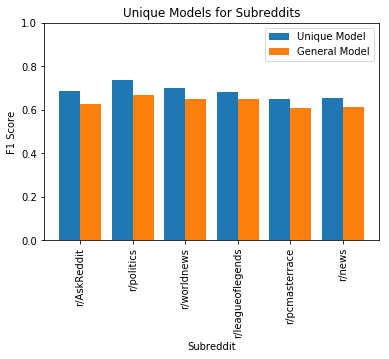

In [24]:
sub_names = list()
for arg in sub_args[:len(sub_scores)]:
    sub_names.append(subs_sorted[arg])

plt.figure()
plt.tight_layout()

plt.bar(range(len(sub_scores)), sub_scores, width=-0.4, align='edge', label="Unique Model")
plt.bar(range(len(sub_scores)), sub_all_scores, width=0.4, align='edge', label="General Model")
#plt.bar(len(sub_), combined_f1, label="All data")
#for i, f1 in enumerate(np.append(sub_scores, combined_f1)):
#    plt.text(i, f1 + 0.02, '%.2f' % f1, horizontalalignment='center', fontsize=12)
plt.xticks(range(len(sub_scores)), ["r/{}".format(sub_name) for sub_name in sub_names], rotation='vertical')
plt.ylim(0,1)

plt.legend()
plt.title("Unique Models for Subreddits")
plt.xlabel("Subreddit")
plt.ylabel("F1 Score")

plt.savefig("graphs/sub_models.png", bbox_inches="tight")

In [26]:
print("r/subreddit - sub_score / general_score\n-------------------")
for i, arg in enumerate(sub_args[:10]):
    print("r/{} - {} / {}".format(subs_sorted[arg], sub_scores[i], sub_all_scores[i]))

r/subreddit - sub_score / general_score
-------------------
r/AskReddit - 0.684 / 0.625
r/politics - 0.737 / 0.6655
r/worldnews - 0.69875 / 0.647
r/leagueoflegends - 0.6825 / 0.64875
r/pcmasterrace - 0.64925 / 0.60725
r/news - 0.6532012195121951 / 0.6112804878048781


IndexError: list index out of range

# Subreddit Model Results

In [45]:
for arg in sub_args[:10]:
    clf = joblib.load("models/subreddits/{}.joblib".format(subs_sorted[arg]))
    print("r/{}:".format(subs_sorted[arg]))
    
    tfidf_vocab = clf.steps[0][1].transformer_list[0][1].steps[1][1].vocabulary_
    weights = clf.steps[1][1].coef_[0, :]
    weight_args = np.flip(np.argsort(weights), axis=-1)
    
    f = open("tables/{}_n_grams.csv".format(subs_sorted[arg]), "w")
    f.write("N-gram, Weight\n")

    i = 0
    for warg in weight_args:
        for key in tfidf_vocab:
            if (tfidf_vocab[key] == warg):
                print("\t{}: {:.3f}".format(key, weights[warg]))
                f.write("\"{}\",{:.2f}\n".format(key, weights[warg]))
                i += 1
                break
        
        if (i >= 20):
            break
    print()
    f.close()

r/AskReddit:
	because: 3.706
	totally: 2.898
	obviously: 2.822
	women: 2.385
	of course: 2.176
	you: 2.152
	clearly: 2.131
	duh: 2.093
	but: 2.006
	course: 1.966
	yeah: 1.954
	must: 1.938
	racist: 1.921
	them: 1.915
	sarcasm: 1.890
	gender: 1.849
	white: 1.830
	so: 1.826
	well: 1.787
	communism: 1.663

r/politics:
	yeah: 5.343
	because: 4.725
	obviously: 3.751
	but: 3.751
	clearly: 3.405
	all: 3.354
	totally: 2.757
	liberal: 2.686
	those: 2.272
	well: 2.188
	white: 2.143
	oh: 2.093
	just: 2.043
	shocked: 1.964
	rigged: 1.946
	smart: 1.886
	hillary: 1.858
	soros: 1.852
	maga: 1.828
	real: 1.825

r/worldnews:
	yeah: 5.342
	because: 5.168
	obviously: 4.015
	but: 3.649
	clearly: 2.846
	racist: 2.788
	totally: 2.777
	sure: 2.766
	all: 2.626
	better: 2.370
	so: 2.245
	fault: 2.154
	such: 1.889
	must: 1.837
	yay: 1.796
	surprise: 1.795
	we: 1.759
	shocked: 1.709
	forgot: 1.690
	course: 1.687

r/leagueoflegends:
	yeah: 5.177
	because: 4.747
	obviously: 3.984
	totally: 3.611
	we: 3.304
	should:

In [30]:
for arg in sub_args[:10]:
    clf = joblib.load("models/subreddits/{}.joblib".format(subs_sorted[arg]))
    print("r/{}:".format(subs_sorted[arg]))
    
    tfidf_vocab = clf.steps[0][1].transformer_list[0][1].steps[1][1].vocabulary_
    parent_vocab = clf.steps[0][1].transformer_list[1][1].steps[1][1].vocabulary_
    weights = clf.steps[1][1].coef_[0, :]
    weight_args = np.flip(np.argsort(weights), axis=-1)
    all_n_len = len(tfidf_vocab) + len(parent_vocab)
    
    f = open("tables/{}_n_grams.csv".format(subs_sorted[arg]), "w")
    f.write("N-gram, Weight\n")

    i = 0
    for warg in weight_args:
        if (warg >= all_n_len + 10 and warg < all_n_len + 110):
            topic_index = warg - (all_n_len + 10)
            print("{}: Topic {} - {}\n\t{}".format(i, topic_index, weights[warg], ldaModel.print_topic(topic_index, topn=20)))
            i += 1
        if (i >= 5):
            print()
            break  

r/AskReddit:
0: Topic 75 - 1.7780009424344112
	0.499*"right" + 0.110*"pay" + 0.061*"gener" + 0.037*"duh" + 0.031*"israel" + 0.026*"conspiraci" + 0.023*"arm" + 0.018*"innoc" + 0.018*"onlin" + 0.017*"billion" + 0.016*"languag" + 0.014*"return" + 0.013*"french" + 0.013*"13" + 0.012*"amend" + 0.010*"filter" + 0.009*"wheel" + 0.007*"hardcor" + 0.007*"guard" + 0.007*"sky"
1: Topic 29 - 1.3590712156177704
	0.405*"use" + 0.119*"caus" + 0.062*"left" + 0.059*"top" + 0.056*"freedom" + 0.035*"product" + 0.028*"earth" + 0.027*"low" + 0.025*"violenc" + 0.018*"canadian" + 0.017*"proud" + 0.017*"repli" + 0.016*"bottom" + 0.016*"west" + 0.012*"welfar" + 0.011*"steve" + 0.008*"sandwich" + 0.007*"kitchen" + 0.007*"inch" + 0.006*"helmet"
2: Topic 64 - 1.2490160616335877
	0.118*"exist" + 0.107*"ya" + 0.083*"appl" + 0.065*"develop" + 0.061*"jew" + 0.048*"le" + 0.046*"repres" + 0.046*"spoiler" + 0.043*"15" + 0.026*"budget" + 0.025*"boot" + 0.023*"dae" + 0.021*"2012" + 0.020*"actor" + 0.018*"directli" + 0.018

r/news:
0: Topic 56 - 2.01643077748907
	0.542*"know" + 0.078*"rape" + 0.058*"opinion" + 0.050*"fix" + 0.046*"deal" + 0.037*"major" + 0.033*"media" + 0.024*"everybodi" + 0.021*"strong" + 0.017*"wrote" + 0.014*"risk" + 0.013*"artist" + 0.007*"mike" + 0.005*"highest" + 0.005*"flavor" + 0.005*"coin" + 0.004*"transit" + 0.004*"upper" + 0.004*"pixel" + 0.004*"clown"
1: Topic 73 - 1.8346514936753713
	0.271*"work" + 0.132*"anyth" + 0.091*"els" + 0.085*"damn" + 0.063*"poor" + 0.058*"glad" + 0.055*"woman" + 0.048*"drive" + 0.035*"commun" + 0.032*"drop" + 0.032*"walk" + 0.020*"imposs" + 0.014*"luck" + 0.011*"soul" + 0.009*"pound" + 0.006*"weak" + 0.005*"overal" + 0.004*"divers" + 0.003*"cynic" + 0.002*"illustr"
2: Topic 30 - 1.8299726226515978
	0.171*"mani" + 0.153*"gun" + 0.149*"countri" + 0.074*"eat" + 0.063*"super" + 0.060*"shoot" + 0.046*"hot" + 0.029*"box" + 0.029*"weed" + 0.025*"cancer" + 0.020*"built" + 0.019*"moon" + 0.017*"cure" + 0.015*"jersey" + 0.014*"stone" + 0.014*"chees" + 0.014*"s

In [40]:
#f = open("tables/sub_n_grams.csv", "w")
#f.write("Subreddit,N-gram,Weight\n")

for sarg in sub_args[:10]:
    clf = joblib.load("models/subreddits/{}.joblib".format(subs_sorted[sarg]))
    print("r/{}:".format(subs_sorted[sarg]))
    
    all_weights = clf.steps[1][1].coef_[0, :]
    weight_args = np.flip(np.argsort(all_weights), axis=-1)
    
    n_gram_vocab = clf.steps[0][1].transformer_list[0][1].steps[1][1].vocabulary_
    n_gram_len = len(n_gram_vocab)

    parent_n_gram_vocab = clf.steps[0][1].transformer_list[1][1].steps[1][1].vocabulary_
    parent_n_gram_len = len(parent_n_gram_vocab)

    all_n_len = n_gram_len + parent_n_gram_len

    all_tags = [
        '$', '\'\'', '(', ')', ',', '--', '.', ':', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS',
        'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM',
        'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB', '``', 'None'
    ]
    all_tag_names = [
        'dollar', 'closing quotation marks', 'opening parantheses', 'closing parantheses', 'comma', 'dash',
        'sentence terminator', 'colon or elipsis', 'conjunction, coordinating', 'numeral, cardinal', 'determiner',
        'exisensial there', 'foreign word', 'preposition or conjunction, subordinating', 'adjective or numeral, ordinal',
        'adjective, comparative', 'adjective, superlative', 'list item marker', 'modal auxiliary',
        'noun, common, singular or mass', 'noun, proper, singular', 'noun, proper, plural', 'noun, common, plural', 'pre-determiner',
        'genitive marker', 'pronoun, personal', 'pronoun, possessive', 'adverb', 'adverb, comparative',
        'adverb, superlative', 'particle', 'symbol', '"to" as preposition or infinitive marker', 'interjection',
        'verb, base form', 'verb, past tense', 'verb, present participle or gerund', 'verb, past participle',
        'verb, present tense, not 3rd person singular', 'verb, present tense, 3rd person singular', 'WH-determiner',
        'WH-pronoun', 'WH-pronoun, possessive', 'Wh-adverb', 'opening quotation mark', 'None'
    ]
    pos_len = len(all_tags)
    
    for i, arg in enumerate(weight_args[:20]):
        if (arg < n_gram_len): # n-grams
            for key in n_gram_vocab:
                if (n_gram_vocab[key] == arg):
                    print("{}: (N-gram) {} - {}".format(i, key, all_weights[arg]))
                    break
        elif (arg >= n_gram_len and arg < all_n_len): # parent n-grams
            for key in parent_n_gram_vocab:
                if (parent_n_gram_vocab[key] == arg):
                    print("{}: (Parent N-gram) {} - {}".format(i, key, all_weights[arg]))
                    break
        elif (arg == all_n_len): # score
            print("{}: Score - {}".format(i, all_weights[arg]))
        elif (arg == all_n_len + 1): # length
            print("{}: Length - {}".format(i, all_weights[arg]))
        elif (arg == all_n_len + 2): # sub sarc
            print("{}: Subreddit Sarcasm - {}".format(i, all_weights[arg]))
        elif (arg >= all_n_len + 3 and arg < all_n_len + 7): # author sarc
            auth_index = arg - (all_n_len + 3)
            if (auth_index == 0):
                print("{}: Author History (Last Month)- {}".format(i, all_weights[arg]))
            elif (auth_index == 1):
                print("{}: Author History (Last Six Months)- {}".format(i, all_weights[arg]))
            elif (auth_index == 2):
                print("{}: Author History (Last Year)- {}".format(i, all_weights[arg]))
            elif (auth_index == 3):
                print("{}: Author History (All time)- {}".format(i, all_weights[arg]))
        elif (arg == all_n_len + 7): # polarity
            print("{}: Polarity - {}".format(i, all_weights[arg]))
        elif (arg == all_n_len + 8): # subjectivity
            print("{}: Subjectivity - {}".format(i, all_weights[arg]))
        elif (arg == all_n_len + 9): # sent diff
            print("{}: Sentiment Difference - {}".format(i, all_weights[arg]))
        elif (arg >= all_n_len + 10 and arg < all_n_len + 110): # topics
            topic_index = arg - (all_n_len + 10)
            print("{}: Topic {} - {}\n\t{}".format(i, topic_index, all_weights[arg], ldaModel.print_topic(topic_index, topn=20)))
        elif (arg >= all_n_len + 110 and arg < all_n_len + 210): # parent topics
            topic_index = arg - (all_n_len + 110)
            print("{}: Parent Topic {} - {}\n\t{}".format(i, topic_index, all_weights[arg], parent_ldaModel.print_topic(topic_index, topn=20)))
        elif (arg >= all_n_len + 210): # pos tags
            tag_index = arg - (all_n_len + 210)
            print("{}: PoS Tag {} - {}".format(i, all_tags[tag_index], all_weights[arg]))

r/AskReddit:
0: (N-gram) because - 3.7057790835977635
1: (N-gram) totally - 2.898263604955807
2: (N-gram) obviously - 2.821728394076539
3: (N-gram) women - 2.384937477597179
4: (N-gram) of course - 2.175677046625652
5: (N-gram) you - 2.1523751074798496
6: (N-gram) clearly - 2.130770388582734
7: (N-gram) duh - 2.092712231765386
9: (N-gram) but - 2.0057253059586055
10: (N-gram) course - 1.9663596915589625
11: (N-gram) yeah - 1.953535070588504
12: (N-gram) must - 1.9376405783737622
13: (N-gram) racist - 1.9211307523411354
14: (N-gram) them - 1.9154353274744584
15: (N-gram) sarcasm - 1.889714136204928
16: (N-gram) gender - 1.8486630623844076
17: (N-gram) white - 1.830029039083133
18: (N-gram) so - 1.8256977403262968
19: (N-gram) well - 1.7871188864794514
r/politics:
0: (N-gram) yeah - 5.342567800050772
1: (N-gram) because - 4.725052197355791
2: (N-gram) obviously - 3.7511628967183066
3: (N-gram) but - 3.750690629936534
4: (N-gram) clearly - 3.4046114111344696
5: (N-gram) all - 3.3542023951

r/nba:
0: (N-gram) yeah - 3.6393025766262332
1: (N-gram) because - 3.217625719142681
2: (N-gram) obviously - 3.1683556762883724
3: (N-gram) scrub - 3.1276363881568763
4: (N-gram) clearly - 2.565547990638482
5: (N-gram) only - 2.5487271888178857
6: (N-gram) but - 2.4242584377469782
7: (N-gram) nah - 2.3174810261628522
8: (N-gram) totally - 2.2364157630381425
9: (N-gram) should - 1.978369793805653
10: (N-gram) racist - 1.9543721263694835
11: (N-gram) yea - 1.8844879025193193
12: (N-gram) bro - 1.8274687795097415
13: (N-gram) sure - 1.8251980519669242
14: (N-gram) white - 1.7946085951545623
15: Topic 55 - 1.74647856187651
	0.597*"yeah" + 0.102*"live" + 0.059*"place" + 0.054*"tax" + 0.022*"current" + 0.020*"bullshit" + 0.020*"canada" + 0.015*"match" + 0.014*"honest" + 0.014*"retard" + 0.009*"microsoft" + 0.007*"retir" + 0.007*"info" + 0.007*"batteri" + 0.005*"consist" + 0.005*"edgi" + 0.005*"hockey" + 0.004*"butter" + 0.004*"sum" + 0.004*"expand"
16: (N-gram) he - 1.7124860511452589
17: (N

In [35]:
lol = joblib.load("models/subreddits/leagueoflegends.joblib")

In [36]:
for i, arg in enumerate(sub_args[:10]):
    if (i == 4):
        continue
        
    sub_test = test_subs.get_group(subs_sorted[arg])
    clf = joblib.load("models/subreddits/{}.joblib".format(subs_sorted[arg]))
    
    eval_summary("r/{}".format(subs_sorted[arg]), lol.predict(sub_test), sub_test['label'])


Confusion matrix:
 [[7971 2850]
 [3314 3895]]
Classifier 'r/AskReddit' has P=0.577 R=0.540 Acc=0.658 F1=0.558
             precision    recall  f1-score   support

          0       0.71      0.74      0.72     10821
          1       0.58      0.54      0.56      7209

avg / total       0.65      0.66      0.66     18030


Confusion matrix:
 [[3118 1530]
 [2584 4657]]
Classifier 'r/politics' has P=0.753 R=0.643 Acc=0.654 F1=0.694
             precision    recall  f1-score   support

          0       0.55      0.67      0.60      4648
          1       0.75      0.64      0.69      7241

avg / total       0.67      0.65      0.66     11889


Confusion matrix:
 [[1571  898]
 [1471 2990]]
Classifier 'r/worldnews' has P=0.769 R=0.670 Acc=0.658 F1=0.716
             precision    recall  f1-score   support

          0       0.52      0.64      0.57      2469
          1       0.77      0.67      0.72      4461

avg / total       0.68      0.66      0.66      6930


Confusion matrix:
 [[1

# Ablation Testing
Testing all features except one.

In [31]:
def ablate(features, original, n=0, saveas=None, eval=False, savemod=None):
    print([feature[0] for feature in features])
    scores = list()
    
    for i in range(len(features)):
        ablation_features = deepcopy(features)
        del ablation_features[i]
        
        clf = Pipeline([
            ('features', FeatureUnion(ablation_features)),
            ('sclaer', MaxAbsScaler()),
            ('clf', LinearSVC(C=0.1))
        ])
        
        clf.fit(train, train['label'])
        if (eval):
            scores.append(eval_summary("Without {}".format(features[i][0]), clf.predict(test), test['label']))
        else:
            scores.append(f1_score(clf.predict(test), test['label']))
            
        del ablation_features
            
    scores = np.array(scores)
    
    plt.figure()
    plt.tight_layout()
    plt.bar(range(len(scores)), scores)
    plt.bar(len(scores), original)
    for i, f1 in enumerate(np.append(scores, original)):
        plt.text(i, f1 + 0.02, '%.2f' % f1, horizontalalignment='center', fontsize=12)
    plt.xticks(range(len(scores) + 1), np.append([feature[0] for feature in features], "none"), rotation="vertical")
    
    plt.ylim((0, 1))
    plt.title("Ablation Testing Round {}".format(n))
    plt.xlabel("Removed Feature")
    plt.ylabel("F1 Score")
    
    if (saveas):
        plt.savefig('graphs/{}_{}.png'.format(saveas, n), bbox_inches="tight")
    plt.show()
        
    best = np.argmax(scores)
    
    if (scores[best] > original):
        new_features = features
        print("Removing {} - {}\n".format(features[best][0], scores[best]))
        del new_features[best]
        return ablate(new_features, scores[best], n=n+1, saveas=saveas)
    else:
        if (savemod is not None):
            joblib.dump(clf, "models/{}.joblib".format(savemod))
        return features

In [32]:
#ablate(features, combined_f1, saveas="ablation_testing")
ablate(deepcopy(good_features), good_scores[-1], saveas="more_ablation", savemod="ablated")

['n_grams', 'parent_n_grams', 'subreddit_sarcasm', 'subjectivity', 'sentence_sentiment_difference', 'topics', 'parent_topics', 'pos_tags']


KeyboardInterrupt: 

In [ ]:
#ablation_f1_results = list()
#
#for i in range(len(features)):
#    ablation_features = features_that_work.copy()
#    del ablation_features[i]
#    print([feature[0] for feature in ablation_features])
#    
#    ablation_pipeline = Pipeline([
#        ('features', FeatureUnion(ablation_features)),
#        #('clf', LinearSVC(C=0.1))
#        ('clf', clf)
#    ])
#    ablation_pipeline.fit(train, train['label'])
#    ablation_f1_results.append(eval_summary("Without %s" %features[i][0], ablation_pipeline.predict(test), test['label']))
#    #ablation_f1_results.append(np.mean(cross_val_score(ablation_pipeline, train, train['label'], cv=5)))

In [ ]:
#plt.bar(range(len(ablation_f1_results)), ablation_f1_results)
#plt.bar(len(ablation_f1_results), combined_f1)
#for i, f1 in enumerate(np.append(ablation_f1_results, combined_f1)):
#    plt.text(i, f1 + 0.02, '%.3f' % f1, horizontalalignment='center', fontsize=12)
#plt.xticks(range(len(ablation_f1_results) + 1), np.append([feature[0] for feature in features], "none"), rotation='vertical')
#plt.ylim(0,1)
#
#plt.title("Ablation Testing")
#plt.xlabel("Removed Feature")
#plt.ylabel("F1 Score")

# Classifier Comparison

In [ ]:
clf_features = FeatureUnion(deepcopy(features))
train_docs = clf_features.fit_transform(train, train['label'])
test_docs = clf_features.transform(test)

In [ ]:
classifiers = [
    ('dummy_most_frequent', DummyClassifier(strategy='most_frequent')),
    ('dummy_stratified', DummyClassifier(strategy='stratified')),
    ('linear_svc', LinearSVC(C=0.1)),
    ('sgd', SGDClassifier(tol=0.001)),
    ('multinomial_naive_bayes', MultinomialNB(alpha=10)),
    ('logistic_regression', LogisticRegression())
    #('knn', KNeighborsClassifier())
]

In [ ]:
classifier_f1 = list()

for classifier in classifiers:
    classifier[1].fit(train_docs, train['label'])
    classifier_f1.append(eval_summary(classifier[0], classifier[1].predict(test_docs), test['label']))
    #print("%s: %.3f" % (classifier[0], np.mean(cross_val_score(classifier[1], train_docs, train['label'], cv=5))))

In [ ]:
plt.bar(range(len(classifier_f1)), classifier_f1)
for i, f1 in enumerate(classifier_f1):
    plt.text(i, f1 + 0.02, '%.3f' % f1, horizontalalignment='center', fontsize=12)
plt.xticks(range(len(classifier_f1)), [classifier[0] for classifier in classifiers], rotation='vertical')
plt.ylim(0,1)

plt.title("Classifier F1 Score Comparison")
plt.xlabel("Classifier")
plt.ylabel("F1 Score")

plt.savefig("graphs/classifier_comparison.png", bbox_inches="tight")